# RL homework 4

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw4.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw4.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)

### Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])
#   plt.colorbar()

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

### A small MRP

In [0]:
class SmallMRP(object):

  def __init__(self, p=0.1):
    self._state = 0
    self._p = p

  def get_state(self):
    return self._state

  def step(self):
    reward = 0
    discount = 1
    if self._state == 0:
      self._state = 1
    else:
      if np.random.random() < self._p:
        self._state = 0
        discount = 0
      else:
        self._state = 1

    return reward, discount, self.get_obs()

## Assignment 1 [50pts in total]

We are going to analyze the simple Markov reward process (MRP - a MRP is an MDP without actions or, equivalently, with a single action in each state) defined in the code cell above.  It consists of two states.  The reward is zero everywhere.  When we are in state $s_0$, we always transition to $s_1$.  If we are in state $s_1$, there is a probability $p$ (which is set to 0.1 by default in the code above) of terminating, after which the next episode starts in $s_0$ again.  With a probability of $1 - p$, we transition from $s_1$ back to itself again.  The discount is $\gamma = 1$ on non-terminal steps.

#### [1pt] Question 1.1
What is the optimal value in each state?

As there are no reward, the optimla value is 0 for each of the two states.

#### [1pt] Question 1.2
Instead of a tabular representation, consider a single feature $\phi$, which takes the values $\phi(s_0) = 1$ and $\phi(s_1) = 4$.  Now consider using linear function approximation, where we learn a value $\theta$ such that $v_{\theta}(s) = \theta \times \phi(s) \approx v(s)$, where $v(s)$ is the true value of state $s$.  What is the optimal value of $\theta$?

The optimal value of $\theta$ is 0 since there is no reward in the MRP. 

#### [8pts] Question 1.3
Suppose $\theta_0 = 1$, and suppose we update this parameter with TD(0) with a step size of $\alpha = 0.1$.  What is the expected value of $\mathbb{E}[ \theta_T ]$ if we step through the MDP until it terminates after the first episode, as a function of $p$?  (Note that $T$ is random.)

The TD(0) update for the parameter using gradient descent:

$\theta_{t+1} = \theta_{t}+\alpha(R+\gamma v_{\theta_{t}}(s')-v_{\theta_{t}}(s))\nabla v_{\theta_{t}}(s)$ with $R=0$

$\theta_{t+1} = \theta_{t}+\alpha(\gamma\theta_{t}\phi(s') -\theta_{t}\phi(s) )\phi(s) = \theta_{t}(1+\alpha(\gamma\phi(s')-\phi(s))\phi(s))$

For $s_{0}\rightarrow s_{1}$ and $s_{1}\rightarrow s_{1}$: $\gamma = 1$; for $s_{1}\rightarrow s_{0}$, $\gamma=0$ as there is no need to boostrap for the terminate state. 

At the start of the episode, we have transition $s_{0}\rightarrow s_{1}$ with $prob=1$ and at the end of the episode with transition $s_{1}\rightarrow s_{0}$ with $prob=p$. The other transitions are T-2 numbers of $s_{1}\rightarrow s_{1}$ with $prob=1-p$

Therefore with $\theta_{0}=1$, $\alpha = 0.1$, $\phi(s_{0})=1$ and $\phi(s_{1})=4$, the expectation could be written as:

$\mathbb{E}[ \theta_T ] = \sum_{T=2}^{\infty}\theta_{0}(1+\alpha(\phi(s_{1})-\phi(s_{0}))\phi(s_{0}))(1+\alpha(\phi(s_{1})-\phi(s_{1}))\phi(s_{1}))^{T-2}(1+\alpha(-\phi(s_{1}))\phi(s_{1}))(1-p)^{T-2}p$


$=1.3\times (-0.6)p\sum_{T=2}^{\infty}(1-p)^{T-2}$

$=-0.78p\times \frac{1}{1-(1-p)} = -0.78p^{0} = -0.78$



#### [5pts] Question 1.3
If $p=0.1$, how many episodes does it take, starting from $\theta_0 = 1$, until $| v(s) - \mathbb{E}[v_{\theta}(s)] | < 0.5$ for all $s$, where the expectation is over the expected updates to $\theta$?

For $p=0.1$, suppose we need $n$ episodes

Since $\mathbb{E}[v_{\theta}(s)] = \mathbb{E}[\phi(s)\theta_{T}] = \phi(s)\mathbb{E}[\theta_{T}]$: 

For $s_{0}$ we have $| v(s_{0}) - \mathbb{E}[v_{\theta}(s_{0})] | = | \phi(s_{0})\mathbb{E}[\theta_{T}] | = | \mathbb{E}[\theta_{T}] | < 0.5$

For $s_{1}$ we have $| v(s_{1}) - \mathbb{E}[v_{\theta}(s_{1})] | = | \phi(s_{1})\mathbb{E}[\theta_{T}] | = 4| \mathbb{E}[\theta_{T}] | < 0.5 \rightarrow | \mathbb{E}[\theta_{T}] | < 0.125$

In this case of n episodes
$\mathbb{E}[ \theta_T ] = \sum_{T=2n}^{\infty}\theta_{0}(1+\alpha(\phi(s_{1})-\phi(s_{0}))\phi(s_{0}))^{n}(1+\alpha(\phi(s_{1})-\phi(s_{1}))\phi(s_{1}))^{T-2n}(1+\alpha(-\phi(s_{1}))\phi(s_{1}))^{n}(1-p)^{T-2}p^{n}$

$=1.3^{n}\times(-0.6)^{n}\times(0.1)^{n}\times \sum_{T=2n}^{\infty}(1-0.1)^{T-2n}$

$=(-0.078)^{n}\times 10 < 0.125$ 

Hence it takes $n=2$ episodes. 

#### Synchronous updates
Consider the following algorithm: we use TD to update the parameters, but instead of using the online data, we assume we can actively sample a transition from both states.  We then update $\theta$ using both samples:
$$
\theta_{n+1} = \theta_n + \alpha \delta_0 \phi(s_0) + \alpha \delta_1 \phi(s_1) \,,
$$
where $\delta_i$ is a sampled one-step TD error when transitioning from state $s_i$.

#### [10pts] Question 1.4

What is the value of $\mathbb{E}[\theta_n]$, as a function of $n$ and $p$?

We have $\delta_0 = \theta_{n}\phi(s_{1})-\theta_{n}\phi(s_{0}) = \theta_{n}(\phi(s_{1})-\phi(s_{0}))$

For transition $s_{1}$ to $s_{0}$ (with $prob = p$): 

$\delta_1  = -\theta_{n}\phi(s_{1}) $

$\theta_{n+1}=\theta_{n}+\alpha\theta_{n}(\phi(s_{1})-\phi(s_{0}))\phi(s_{0})+\alpha\theta_{n}(-\phi(s_{1})\phi(s_{1}))$

$ = \theta_{n}(1+\alpha(\phi(s_{1})\phi(s_{0})-\phi(s_{0})\phi(s_{0})-\phi(s_{1})\phi(s_{1}))) = \theta_{n}\Delta_{10}$

For transition $s_{1}$ to $s_{1}$ (with $prob = 1-p$): 

$\delta_1  = 0 $

$\theta_{n+1}=\theta_{n}+\alpha\theta_{n}(\phi(s_{1})-\phi(s_{0}))\phi(s_{0})$

$=\theta_{n}(1+\alpha(\phi(s_{1})\phi(s_{0})-\phi(s_{0})\phi(s_{0})))=\theta_{n}\Delta_{11}$

Therefore the expectation will be:

$\mathbb{E}[\theta_{T}] = \sum_{k=1}^{n}\theta_{0}(\Delta_{10})^{k}p^{k}(\Delta_{11})^{n-k}(1-p)^{n-k}$

Therefore with $\theta_{0}=1$, $\alpha = 0.1$, $\phi(s_{0})=1$ and $\phi(s_{1})=4$, the expectation could be written as:

$\mathbb{E}[\theta_{T}] = \sum_{k=1}^{n}(-0.3)^{k}p^{k}(1.3)^{n-k}(1-p)^{n-k}$

$ = (1.3(1-p))^{n}\sum_{k=1}^{n}(\frac{-0.3p}{1.3(1-p)})^{k} = (1.3(1-p))^{n}\frac{w(1-w^{n-1})}{1-w}$, where $w = \frac{-0.3p}{1.3(1-p)}$

$ = (-0.3p(1.3(1-p))^{n-1}-(-0.3p)^{n})/(1+\frac{0.3p}{1.3(1-p)})$

#### [5pts] Question 1.5

For which values of $p$ does not $\theta$ converge to the optimal solution?

On basis of the expression from last question: 

if $1.3(1-p)>1 \rightarrow p<\frac{3}{13}$ then $(1.3(1-p))^{n-1}\rightarrow \infty$ as $n \rightarrow \infty$

And thus $\theta$ will not converge to the optimal solution

#### [10pts] Question 1.5
Why doesn't it?  TD is known to converge, with linear function approximation, under certain assumptions.  Explain for this concrete case why the algorithm does not converge, and explain which general assumption is violated that would otherwise ensure convergence of linear TD (in at most 200 words).

Refer to Q1.4, we have got the update funciton for $\theta$:

let $\phi_0 = \phi(s_{0})$, $\phi_1 = \phi(s_{1})$

With $prob=p$:

$\theta_{n+1} = \theta_{n}+\alpha\theta_{n}(\phi_1\phi_0-\phi_0\phi_0-\phi_1\phi_1) = (1-\alpha A)\theta_{n}$

where $A = \phi_0\phi_0+\phi_1\phi_1-\phi_1\phi_0$

with $prob=1-p$:

$\theta_{n+1} = \theta_{n}+\alpha\theta_{n}(\phi_1\phi_0-\phi_0\phi_0) = (1-\alpha A)\theta_{n}$

Where $A = \phi_0\phi_0-\phi_1\phi_0$

The expectation of the update will be: 

$\mathbb{E}[\theta_{n+1} | \theta_{n}] = (1-\alpha\mathbb{E}[A])\theta_{n}$ 

And $\mathbb{E}[A] = p(\phi_0\phi_0+\phi_1\phi_1-\phi_1\phi_0)+(1-p)(\phi_0\phi_0-\phi_1\phi_0) = \phi_0\phi_0+p\phi_1\phi_1-\phi_1\phi_0$

which could be written as $\mathbb{E}[A] = \mu^{T}P \mu$ 

where $\mu = \begin{pmatrix}\phi_0\\\phi_1\end{pmatrix}$ and $P = \begin{pmatrix} 1 & b \\c & p \end{pmatrix}$ with $b+c=-1$ 

$P$ might not be positive definite with specific value of $p$ and hence $\mathbb{E}[A]$ might not be positive definite.

(In our case of $\phi_0=1$ and $\phi_1=4$, $\mathbb{E}[A] = 16p-3$. It cannot be guaranteed to be larger than 0. 

If $\mathbb{E}[A]<0$, we have $(1-\alpha\mathbb{E}[A])>0$ for all $\alpha$. Therefore the update of $\theta_t$ will be amplified which will lead to divergence. )

In such a scenario, matrix/value $\mathbb{E}[A]$ should be positive (definite) in the general case. The assumption that $\gamma<1$ is also violated which is used to ensure the property of positive defenite. 

Furthmore, this sychronous update algorithm combine (linear) function approximation, boostrap(TD(0)) and off policy all together, which might cause Deadly Triad issue and lead to problem of instability and divergence. 

#### [10pts] Question 1.5
Describe a way to change the algorithm to obtain convergence of $\theta$, for any $p$, without changing the sampling or the value function (which should remain as $v_{\theta}(s) = \theta \times \phi(s)$).  Note that the sampling is not sequential, so for instance you cannot add memory of previous states.  (At most 200 words.)

We could change algorithm to use online update instead of offline update which will not lead to deadly triad.

Furthermore, We could change the synchronous update algorithm to: do not update the parameter ($\theta$) if sample to transit from state 1 to itself at state 1 (with $prob=1-p$). Follow this algorithm, $\mathbb{E}[A]$ in the expectation of each update $\mathbb{E}[\theta_{n+1} | \theta_{n}]$will become: 

$\mathbb{E}[A] = p(\phi_0\phi_0+\phi_1\phi_1-\phi_1\phi_0) = 13p > 0$ for all $p$ (with $\phi_0=1$ and $\phi_1=4$)

which could be written as $\mathbb{E}[A] = \mu^{T}\begin{pmatrix} 1 & b \\c & 1 \end{pmatrix} \mu$ where $\mu = \begin{pmatrix}\phi_0\\\phi_1\end{pmatrix}$

$P = \begin{pmatrix} 1 & b \\c & 1 \end{pmatrix}$ with $b+c=-1$

Hence $\mathbb{E}[A]$ must be positive (definite) since P is positive definite and the algorithm is guanranteed to converge.


## Assignment 2 [50pts in total + 10 BONUS pts]

### A grid world

In [0]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(3, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = 0.98
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      reward = (new_y + new_x) / np.sum(self._layout.shape)
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

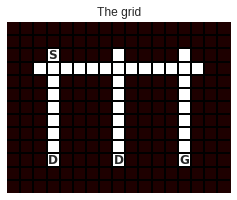

In [5]:
grid = Grid()
grid.plot_grid()


## Implement agents
**[10 pts]** In the next code cell, implement an agent that uses **tabular Sarsa** to learn action values.  The agent should act according to an $\epsilon$-greedy policy with respect to its action values.

The agent will be initialized with:
```
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              grid.get_obs())
```

In [0]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self.state = initial_state
    self.action = 0
    self.q = np.zeros([number_of_states,number_of_actions])
    self.alpha = step_size
    
  @property
  def q_values(self):
    # This function should return the action values for all states and actions
    # in a numpy arrar of shape (number_of_states, number_of_actions)
    return self.q

  def step(self, r, g, s):
    # This function should return an action
    next_a = epsilon_greedy(self.q[s,:], epsilon=0.1)
    self.q[self.state,self.action] += self.alpha*(r+g*self.q[s,next_a]-self.q[self.state,self.action])
    self.state = s
    self.action = next_a
    return self.action

**[20 pts]** Implement an agent that uses **neural Sarsa** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

You are allowed, but not mandated, to use TensorFlow to implement this agent.  (The network is small enough that you can also use numpy, but then you have to implement your own backprop.)  Please document the code clearly, especially on non-trivial operations.

In [0]:
class NeuralSarsa(object):

  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.01):
    self.state = initial_state
    self.action = 0
    # initialize the weight and bias in the NN
    self.W1 = np.random.uniform(-0.05,0.05,[number_of_features,number_of_hidden])
    self.b1 = np.zeros(number_of_hidden)
    self.W2 = np.random.uniform(-0.05,0.05,[number_of_hidden,number_of_actions])
    self.b2 = np.zeros(number_of_actions)    
    self.alpha = step_size
    self.all_a = np.eye(number_of_actions)
    
  def forward(self,x):
    h = x.dot(self.W1)+self.b1
    relu = np.maximum(h,0)
    z = relu.dot(self.W2)+self.b2
    return h,relu,z
  
  def gradients(self,x,W,dL_dz):
    dL_dW = np.dot(x.reshape(-1,1),dL_dz.reshape(1,-1))
    dL_db = np.copy(dL_dz)
    dL_dx = np.dot(W,dL_dz)
    return dL_dW,dL_db,dL_dx
  
  def ReLU_gradients(self,dL_dz,x):
    return dL_dz*(x>0)
  
  def q(self, obs):
    # This function should give the vector of action values for observation obs
    _,_,z = self.forward(obs.reshape(-1,))
    return z
  
  def step(self, r, g, s):
    # This function should return an action
    Q_s = self.q(s)
    next_a = epsilon_greedy(Q_s,epsilon=0.1)
#     target[self.action] = r+g*(self.q(s)[next_a])
    # Forward:
    h,relu,z = self.forward(self.state.reshape(-1,))
    # Target:
    target = np.copy(z)
    target[self.action] = r+g*(Q_s[next_a])
    # Backward:
    dL_dz = -(target-z)
    dW2,db2,drelu = self.gradients(relu,self.W2,dL_dz)
    dh = self.ReLU_gradients(drelu,h)
    dW1,db1,_ = self.gradients(self.state.reshape(-1,),self.W1,dh)
    # update:
    self.W1 -= self.alpha * dW1
    self.b1 -= self.alpha * db1
    self.W2 -= self.alpha * dW2
    self.b2 -= self.alpha * db2
    
    self.state = s
    self.action = next_a
    
    return self.action
  

# Analyse Results - (using Python 2)

### Run the cells below to train the tabular and neural SARSA agents and to generate plots.

This trains the agents the Grid problem with an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

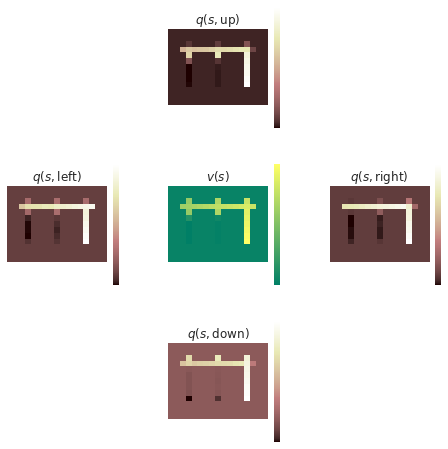

In [74]:
grid = Grid()
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              initial_state = grid.get_obs())
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

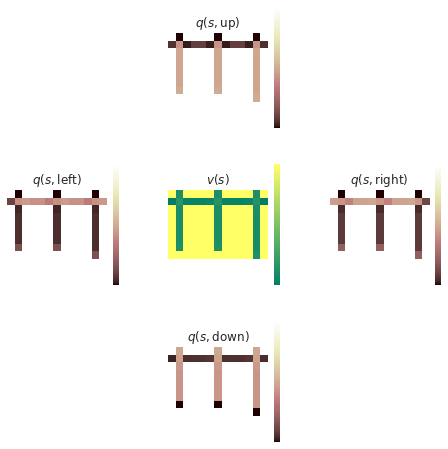

In [7]:
vision_size = 1
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

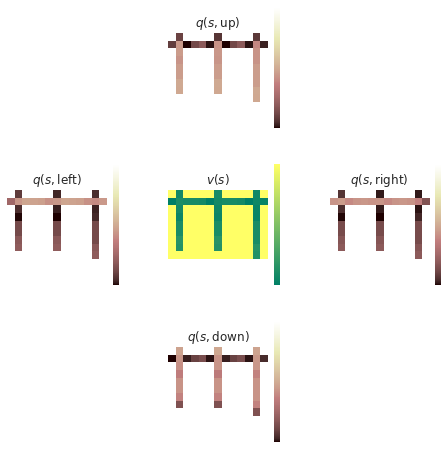

In [77]:
vision_size = 2
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

## Questions

Consider the greedy policy with respect to the estimated values

**[5 pts]** Which algorithm performed best?  Why?

Tabular Sarsa performs the best as it could find the optimal solution which will reach the goal at bottom right based on the value plot. However, neural sarsa cannot distinguish among the paths approach to goal point and two distractor points according to the action value plot. It could be attributed to that the feature vector of most states along the three corridors of the grid will be nearly the same on basis of the way to get feature vector through clipping (0,1).

**[5 pts]** Is there a difference in the solution found by Neural Sarsa with a vision size of 1 (so 3x3 local observations), and a vision size of 2 (so 5x5 local observations)?  Why?

There is no difference in the solution found by Neural Sarsa with a vision size of 1 and 2. For the reason, it can be refered back to the implementation of the environment. For both vision size, the feature representation of most states along the three corridors to the goal or distractor "goal" are the same through clipping (min=0, max=1). Neural sarsa cannot identified the real position in the grid due to the same feature representation. Only the states near the actual goal or distractors have different feature vector. Therefor, our neural sarsa cannot distinguish between the path to the actual goal and the paths to distractors. And that's why there is no difference in the solutions the algorithm found. (In addition, the value estimates only differ slightly for the horizontal and vertical path according to the plot.)

**[10 pts]** How could we improve the performance of the Neural Sarsa agent on this domain (for both vision sizes)?  Identify the main issue, and propose a concrete solution (in max 200 words).

The main issue is how to make more updates for the states near the actual goal point. And further learn the difference between the path to Goal and the paths to two distractor points. Instead of update the paramter one by one accroding to the current transition, we could try to use recurrent neural network (LSTM/GRU) as the network in Neural Sarsa. By using RNN, we are building a memory of the history traisions of states, and the action value will be learned not only based on the current feature representation of the state but also the previous history. As a result, the states on three verticle paths will be distinguished with consideration of the previous states in the transition path. And thus the performance of Neural Sarsa is improved. 

Other solution could be using n step temperal difference instead of TD(0). Through this change, the action value to move in the right direction can be increased, and the policy will encourage the agent to move to the actual goal. 

**[10 BONUS pts]** Implement your proposed improvement and show that it actually helps performance.